<a href="https://www.kaggle.com/code/artemsilvander/face-recognition-emotions-2-model-experiments?scriptVersionId=119692444" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# let's see what is in labels file

import pandas as pd
from cv2 import cv2
import matplotlib.pyplot as plt  # plot
import os
from os.path import join

path = ('/kaggle/input/affectnet-training-data/')
file = (path + 'labels.csv')
df = pd.read_csv(file)
df.head()

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


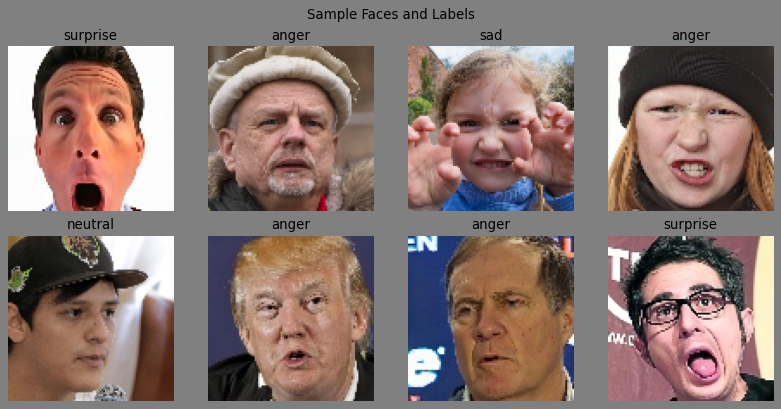

In [2]:
# display random images

import random

fig, axs = plt.subplots(2, 4, sharey=True, constrained_layout=True, num=None, 
                        figsize=(10, 5), dpi=80, facecolor='gray', edgecolor='k')
fig.suptitle("Sample Faces and Labels")
axs = axs.flatten()


for i in range(8):
    idx = random.randint(0, len(df)-1)  # randomly select an index
    img_path = path + df['pth'][idx]
    img = cv2.imread(img_path)  # read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert to BGR to RGB
    axs[i].imshow(img)
    axs[i].set_title(df['label'][idx])
    axs[i].axis('off')
    

AffectNet is a large database of faces labeled by "affects" (psychological term for facial expressions). In order to accommodate common memory constraints, the resolution was reduced down to 96x96. Meaning that all images are exactly 96x96 pixels.

# Load images and label categories

In [3]:
# 1. define functions to pre-process and load images into arrays / label from folders


import cv2
import numpy as np
from keras.utils import to_categorical
import os

INPUT_PATH = "/kaggle/input/affectnet-training-data/"
EMOTIONS = [f.name for f in os.scandir(INPUT_PATH) if f.is_dir()]
IMAGE_SIZE = (96, 96)

print(EMOTIONS)

def image_generator(input_path, emotions, image_size):
    for index, emotion in enumerate(emotions):
        for filename in os.listdir(os.path.join(input_path, emotion)):
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            #img = cv2.resize(img, image_size)
            #img = img.astype('float32') / 255.0  # Normilize
            yield img, index

def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = to_categorical(np.array(y))
    return X, y

['surprise', 'fear', 'neutral', 'sad', 'disgust', 'contempt', 'happy', 'anger']


In [4]:
# Load the images 1
X, y = load_images(INPUT_PATH, EMOTIONS, IMAGE_SIZE)
input_shape = X[0].shape
#input_shape = (96,96,1) 

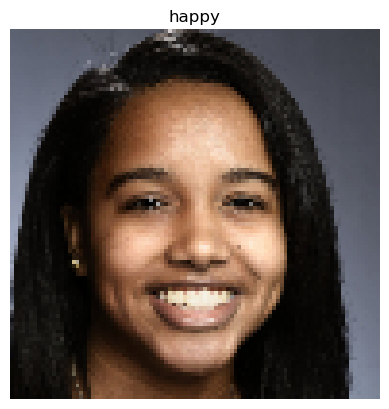

In [5]:
# choose a random image index
idx = np.random.randint(len(X))

# display the image and its corresponding label from arrays
plt.imshow(X[idx])
plt.title(EMOTIONS[np.argmax(y[idx])])
plt.axis('off')  # remove the grid
plt.show()


In [6]:
# Train test split pre-processed data

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Model_2 from Tuning template

In [7]:
# our updated model

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model_2 = Sequential()

model_2.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3,3), activation="selu"))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(128, (3,3), activation="selu"))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(256, activation='selu', kernel_regularizer=l2(0.01)))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(8, activation='softmax'))

model_2.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 45, 45, 64)       2

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history = model_2.fit(X_train, y_train, batch_size=64,
                    epochs=25,
                    validation_data=(X_test, y_test),
                    
                    callbacks = [EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
                                 ReduceLROnPlateau(patience=2, verbose=1),
                                 ModelCheckpoint('best_model.h5', 
                                                 save_best_only=True, 
                                                 save_weights_only=True, 
                                                 monitor='val_accuracy', 
                                                 mode='max')],
                    verbose=1)

Epoch 1/25
364/364 [==============================] - 14s 21ms/step - loss: 3.9588 - accuracy: 0.4421 - val_loss: 2.9256 - val_accuracy: 0.4054 - lr: 0.0010
Epoch 2/25
364/364 [==============================] - 7s 19ms/step - loss: 2.1990 - accuracy: 0.5302 - val_loss: 2.0582 - val_accuracy: 0.5452 - lr: 0.0010
Epoch 3/25
364/364 [==============================] - 7s 19ms/step - loss: 2.0710 - accuracy: 0.5509 - val_loss: 2.0071 - val_accuracy: 0.5464 - lr: 0.0010
Epoch 4/25
364/364 [==============================] - 7s 19ms/step - loss: 1.9987 - accuracy: 0.5701 - val_loss: 2.0309 - val_accuracy: 0.5547 - lr: 0.0010
Epoch 5/25
364/364 [==============================] - 7s 19ms/step - loss: 1.9574 - accuracy: 0.5775 - val_loss: 1.9707 - val_accuracy: 0.5671 - lr: 0.0010
Epoch 6/25
364/364 [==============================] - 7s 19ms/step - loss: 1.9721 - accuracy: 0.5888 - val_loss: 1.9856 - val_accuracy: 0.5767 - lr: 0.0010
Epoch 7/25
362/364 [============================>.] - ETA: 0s -

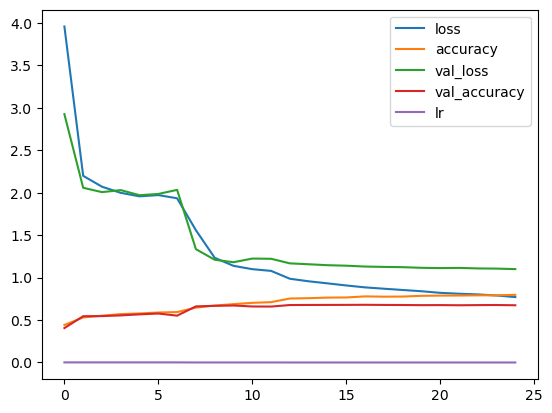

In [9]:
pd.DataFrame(history.history).plot();

182/182 [==============================] - 1s 4ms/step


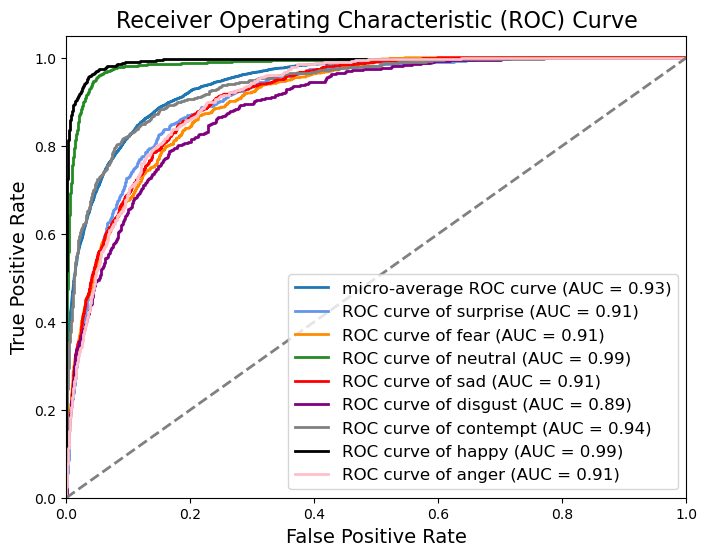

In [10]:
# calculates the false positive rate, true positive rate, and AUC score

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Make predictions
y_pred = model_2.predict(X_test)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC score
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = roc_auc_score(y_test, y_pred, multi_class='ovr')

# Plot the ROC curves for each class and the micro-average ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr["micro"], tpr["micro"], lw=lw, label='micro-average ROC curve (AUC = {0:0.2f})'
                                                   ''.format(roc_auc["micro"]))
colors = ['cornflowerblue', 'darkorange', 'forestgreen', 'red', 'purple', 'gray', 'black', 'pink']
for i, color in zip(range(8), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (AUC = {1:0.2f})'.format(EMOTIONS[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()



In [11]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model_2.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))

182/182 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.57      0.62      0.60       787
           1       0.62      0.44      0.51       685
           2       0.85      0.91      0.88      1026
           3       0.54      0.54      0.54       603
           4       0.46      0.45      0.46       476
           5       0.57      0.74      0.64       564
           6       0.92      0.90      0.91      1018
           7       0.55      0.49      0.51       650

    accuracy                           0.67      5809
   macro avg       0.64      0.64      0.63      5809
weighted avg       0.67      0.67      0.67      5809



# More complex model

In [12]:
# our new model_3

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model_3 = Sequential()

model_3.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(64, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(Conv2D(64, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(128, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(Conv2D(128, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(256, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(Conv2D(256, (3,3), activation="selu"))
model_3.add(BatchNormalization())
model_3.add(MaxPool2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(128, activation='selu', kernel_regularizer=l2(0.01)))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))
model_3.add(Dense(8, activation='softmax'))

model_3.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_3.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_4 (Batc  (None, 94, 94, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 45, 45, 64)      

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history = model_3.fit(X_train, y_train, batch_size=64,
                    epochs=25,
                    validation_data=(X_test, y_test),
                    
                    callbacks = [EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
                                 ReduceLROnPlateau(patience=2, verbose=1),
                                 ModelCheckpoint('best_model.h5', 
                                                 save_best_only=True, 
                                                 save_weights_only=True, 
                                                 monitor='val_accuracy', 
                                                 mode='max')],
                    verbose=1)

Epoch 1/25
364/364 [==============================] - 12s 30ms/step - loss: 2.9515 - accuracy: 0.4159 - val_loss: 1.7011 - val_accuracy: 0.5474 - lr: 0.0010
Epoch 2/25
364/364 [==============================] - 11s 29ms/step - loss: 1.4934 - accuracy: 0.5441 - val_loss: 1.2990 - val_accuracy: 0.5471 - lr: 0.0010
Epoch 3/25
364/364 [==============================] - 10s 28ms/step - loss: 1.2266 - accuracy: 0.5859 - val_loss: 1.1816 - val_accuracy: 0.5913 - lr: 0.0010
Epoch 4/25
364/364 [==============================] - 10s 28ms/step - loss: 1.1434 - accuracy: 0.6129 - val_loss: 1.1252 - val_accuracy: 0.6123 - lr: 0.0010
Epoch 5/25
364/364 [==============================] - 11s 29ms/step - loss: 1.0969 - accuracy: 0.6318 - val_loss: 1.1182 - val_accuracy: 0.6173 - lr: 0.0010
Epoch 6/25
364/364 [==============================] - 10s 28ms/step - loss: 1.0597 - accuracy: 0.6457 - val_loss: 1.0759 - val_accuracy: 0.6335 - lr: 0.0010
Epoch 7/25
364/364 [==============================] - 10s 

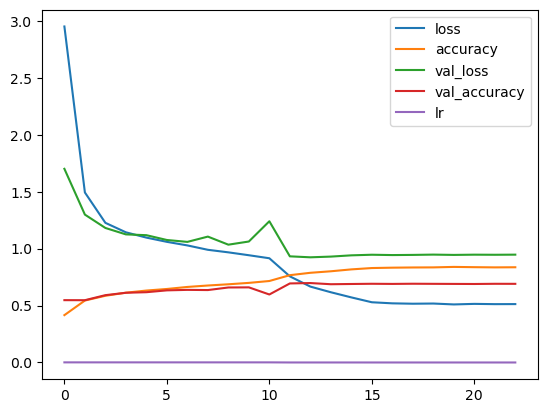

In [14]:
pd.DataFrame(history.history).plot();

182/182 [==============================] - 1s 5ms/step


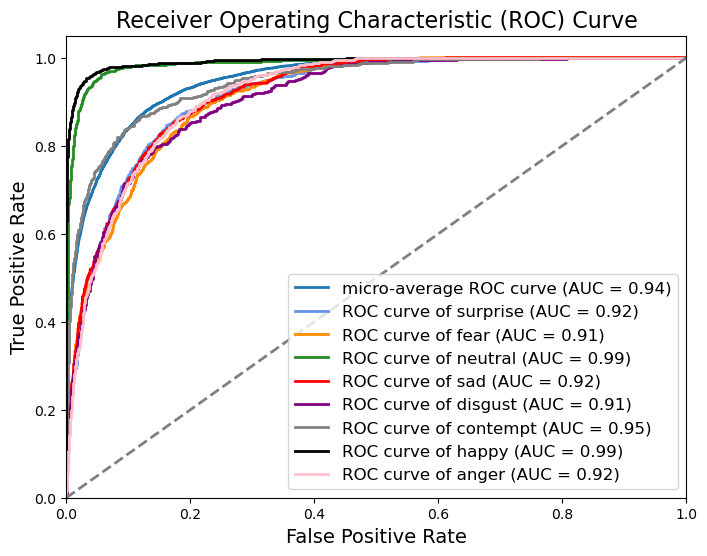

In [15]:
# calculates the false positive rate, true positive rate, and AUC score

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Make predictions
y_pred = model_3.predict(X_test)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC score
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = roc_auc_score(y_test, y_pred, multi_class='ovr')

# Plot the ROC curves for each class and the micro-average ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr["micro"], tpr["micro"], lw=lw, label='micro-average ROC curve (AUC = {0:0.2f})'
                                                   ''.format(roc_auc["micro"]))
colors = ['cornflowerblue', 'darkorange', 'forestgreen', 'red', 'purple', 'gray', 'black', 'pink']
for i, color in zip(range(8), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (AUC = {1:0.2f})'.format(EMOTIONS[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()


In [16]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model_3.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))

182/182 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       787
           1       0.61      0.50      0.55       685
           2       0.88      0.90      0.89      1026
           3       0.56      0.55      0.55       603
           4       0.50      0.49      0.50       476
           5       0.62      0.73      0.67       564
           6       0.92      0.91      0.92      1018
           7       0.55      0.53      0.54       650

    accuracy                           0.69      5809
   macro avg       0.65      0.66      0.65      5809
weighted avg       0.69      0.69      0.69      5809



# Complex model with agressive dropouts 

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

model_4 = Sequential()

model_4.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.3))

model_4.add(Conv2D(64, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(Conv2D(64, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.4))

model_4.add(Conv2D(128, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(Conv2D(128, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.5))

model_4.add(Conv2D(256, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(Conv2D(256, (3,3), activation="selu"))
model_4.add(BatchNormalization())
model_4.add(MaxPool2D(pool_size=(2,2)))
model_4.add(Dropout(0.6))

model_4.add(Flatten())
model_4.add(Dense(128, activation='selu', kernel_regularizer=l2(0.01)))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.5))
model_4.add(Dense(8, activation='softmax'))

model_4.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_4.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 94, 94, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 45, 45, 64)      

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

history = model_4.fit(X_train, y_train, batch_size=128,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    
                    callbacks = [EarlyStopping(patience=10, monitor='val_loss', mode='min'), 
                                 ReduceLROnPlateau(monitor='val_loss', 
                                                   factor=0.5, 
                                                   patience=2, 
                                                   verbose=1),
                                 ModelCheckpoint('best_model.h5', 
                                                 save_best_only=True, 
                                                 save_weights_only=True, 
                                                 monitor='val_accuracy', 
                                                 mode='max')],
                    verbose=1)

Epoch 1/30
182/182 [==============================] - 11s 53ms/step - loss: 3.6254 - accuracy: 0.3286 - val_loss: 2.4488 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 2/30
182/182 [==============================] - 9s 49ms/step - loss: 2.1172 - accuracy: 0.4610 - val_loss: 1.6155 - val_accuracy: 0.5350 - lr: 0.0010
Epoch 3/30
182/182 [==============================] - 9s 49ms/step - loss: 1.5378 - accuracy: 0.5139 - val_loss: 1.3443 - val_accuracy: 0.5567 - lr: 0.0010
Epoch 4/30
182/182 [==============================] - 9s 49ms/step - loss: 1.3199 - accuracy: 0.5497 - val_loss: 1.2229 - val_accuracy: 0.5726 - lr: 0.0010
Epoch 5/30
182/182 [==============================] - 9s 49ms/step - loss: 1.2364 - accuracy: 0.5745 - val_loss: 1.1322 - val_accuracy: 0.6096 - lr: 0.0010
Epoch 6/30
182/182 [==============================] - 9s 48ms/step - loss: 1.1835 - accuracy: 0.5901 - val_loss: 1.1490 - val_accuracy: 0.6066 - lr: 0.0010
Epoch 7/30
182/182 [==============================] - 10s 52ms/

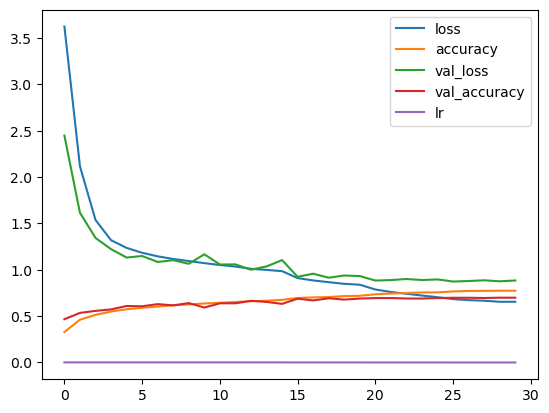

In [19]:
pd.DataFrame(history.history).plot();

182/182 [==============================] - 1s 5ms/step


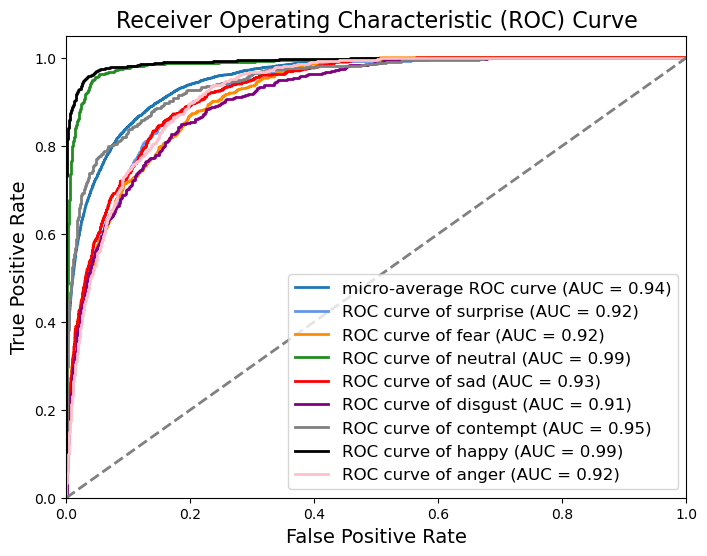

In [20]:
# calculates the false positive rate, true positive rate, and AUC score

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Make predictions
y_pred = model_4.predict(X_test)

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC score
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = roc_auc_score(y_test, y_pred, multi_class='ovr')

# Plot the ROC curves for each class and the micro-average ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr["micro"], tpr["micro"], lw=lw, label='micro-average ROC curve (AUC = {0:0.2f})'
                                                   ''.format(roc_auc["micro"]))
colors = ['cornflowerblue', 'darkorange', 'forestgreen', 'red', 'purple', 'gray', 'black', 'pink']
for i, color in zip(range(8), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (AUC = {1:0.2f})'.format(EMOTIONS[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()


In [21]:
# Compute classification report

from sklearn.metrics import classification_report

# Convert one-hot encoded y_test back to integers
y_test_int = np.argmax(y_test, axis=1)

# Make predictions
y_pred = model_4.predict(X_test)

# Convert one-hot encoded y_pred back to integers
y_pred_int = np.argmax(y_pred, axis=1)

# Generate classification report
print(classification_report(y_test_int, y_pred_int))

182/182 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.59      0.61      0.60       787
           1       0.64      0.50      0.57       685
           2       0.87      0.90      0.89      1026
           3       0.57      0.60      0.58       603
           4       0.52      0.54      0.53       476
           5       0.62      0.76      0.68       564
           6       0.92      0.92      0.92      1018
           7       0.58      0.52      0.55       650

    accuracy                           0.70      5809
   macro avg       0.66      0.67      0.66      5809
weighted avg       0.70      0.70      0.70      5809



Ok, some solid improvements with the model has been done.

The next step - to test the model on RAW data. It will be fun :)

Also, it will be interesting to join 2 models for age + emotions prediction and play with that on real RAW images